In [3]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from qutip import *
import matplotlib.gridspec as gridspec
from scipy.integrate import trapezoid
from qutip import wigner
from tqdm.auto import tqdm

In [ ]:
N = 30 #Hilbert space cutoff per mode¨

cat_state = (coherent(N,alpha=1) - coherent(N,alpha=-1)).unit()

sq = squeeze(N, z = np.log(1.2))

cat_state_squeezed = (sq * cat_state).unit()

x = np.linspace(-5, 5, 100)

p = np.linspace(-5, 5, 100)

cat_W = wigner(cat_state_squeezed, x, p)

# vi behøves ikke at have density matrices fordi vi har ikke losses med endnu, så derfor kan cat bare være en ket state.

$|CAT\rangle_{1} \otimes |CAT\rangle_{2}$

In [5]:
two_mode_cat_begin = tensor(cat_state_squeezed, cat_state_squeezed)


$BS(\theta) |CAT\rangle_{1} \otimes |CAT\rangle_{2}$

In [6]:
def BS(T, N1, N2, input_state):
    """
    Beam splitter operator with transmissivity eta.
    Works on density matrices only.
    """

    a1, a2 = destroy(N1), destroy(N2)

    # angle from transmissivity
    eta = 1/T
    theta = np.arccos(np.sqrt(eta))

    # quadratures
    x1 = (a1 + a1.dag()) / np.sqrt(2)
    p1 = 1j * (a1.dag() - a1) / np.sqrt(2)
    x2 = (a2 + a2.dag()) / np.sqrt(2)
    p2 = 1j * (a2.dag() - a2) / np.sqrt(2)

    # BS generator
    H_BS = 1j * theta * (tensor(p1, x2) - tensor(x1, p2))
    U_BS = H_BS.expm()

    if input_state.isket:
        input_state = input_state * input_state.dag()

    out_put = U_BS * input_state * U_BS.dag()

    return out_put  # normalize


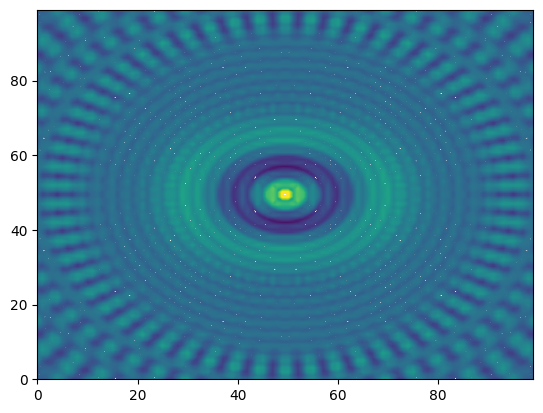

In [7]:
cat_out_mode1and2 = BS(2, N, N, two_mode_cat_begin)
wigner_ = wigner(cat_out_mode1and2, x, p)
plt.contour(wigner_, levels=1000)

So now I have a two-mode squeezed cat state after the beam splitter.

I am assuming the P output is 0, which is a squeezed vacuum state, since our fockspace not can be infinite-dimensional.

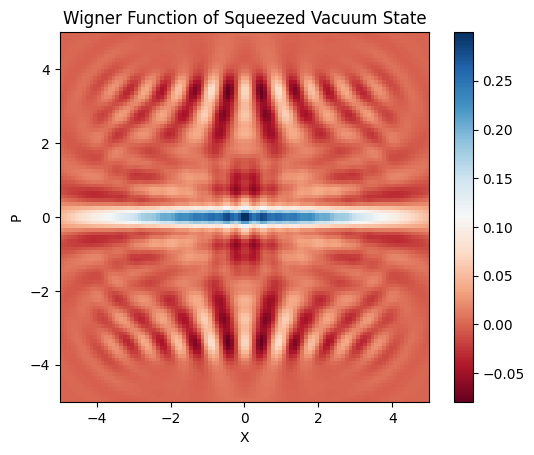

In [8]:
vac = basis(N, 0)
r_vac =4
vac_squeezed = squeeze(N, z = r_vac) * vac.unit()

vac_wigner = wigner(vac_squeezed,x,p)
plt.figure()
plt.imshow(vac_wigner, extent=[-5, 5, -5, 5], cmap='RdBu')
plt.title('Wigner Function of Squeezed Vacuum State')
plt.xlabel('X')
plt.ylabel('P')
plt.colorbar()
plt.show()

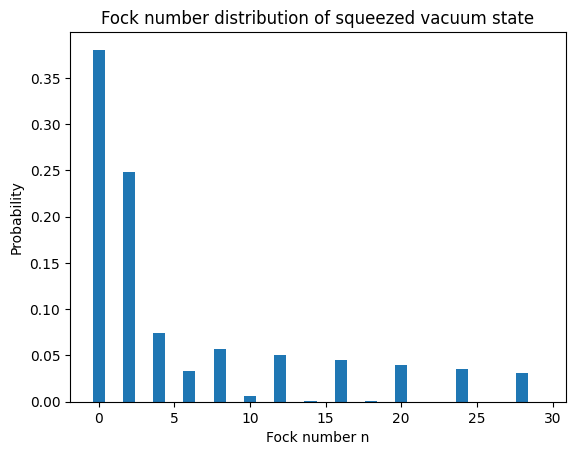

In [9]:
n = np.arange(N)  # Fock numbers
probs = np.abs(vac_squeezed.full())**2  # |<n|psi>|^2
probs = probs.flatten() 
plt.bar(n, probs)
plt.xlabel("Fock number n")
plt.ylabel("Probability")
plt.title("Fock number distribution of squeezed vacuum state")
plt.show()

In [10]:
vac = basis(N, 0)
vac_squeezed = squeeze(N, z = r_vac) * vac.unit()
p0_DM =  vac_squeezed * vac_squeezed.dag()
p0_DM_full = tensor(qeye(N), p0_DM)  # expand P0_DM
print(cat_out_mode1and2.shape)
cat_out_mode1and2.shape
projection_of_mode_1 = ( p0_DM_full * cat_out_mode1and2).ptrace(1) # 0 is mode 1, and 1 is mode 2

(900, 900)


In [11]:
def cat_breeding(eta, N ):

    #creating squeezed vacuum density matrix and make it N^2 dimensions
    vac = basis(N, 0)
    vac_squeezed = squeeze(N, z = 6) * vac.unit()
    vac_DM = vac_squeezed * vac_squeezed.dag()
    vac_DM_full = tensor(qeye(N), vac_DM)  # Projector for mode 2

    #creating two-mode cat state
    cat_state = (coherent(N,alpha=1) - coherent(N,alpha=-1)).unit()
    mu = np.sqrt(3/2 * np.pi)
    
    sq = squeeze(N, z = np.log(mu))

    cat_state_squeezed = (sq * cat_state).unit()
    cat_DM = cat_state_squeezed * cat_state_squeezed.dag()

    mode_2_list = []
    current_state_ket = cat_state_squeezed
    current_state_DM = cat_state_squeezed
    cat_out_list = []

    for i in range(len(eta)):
        if current_state_ket.isket:
            # For ket input
            cat_two = tensor(current_state_ket, cat_state_squeezed)
            # For density matrix input
        else:
            cat_two = tensor(current_state_DM, cat_DM)

        cat_out = BS(eta[i],N, N, cat_two)
        cat_out_list.append(cat_out)

        if cat_out.isket:
            # For ket input
            projected = (vac_DM_full * cat_out.proj()).ptrace(1)
        else:
            # For density matrix input
            projected = (vac_DM_full * cat_out).ptrace(1)

        # Update current state and cat_DM for next iteration
        current_state_ket = projected
        current_state_DM = projected

        mode_2_list.append(projected)

    return mode_2_list, cat_out_list


In [12]:
eta_list = np.arange(2,5)

cat_states, cat_out_mode12 = cat_breeding(eta_list, N=10)

wigner_cat = []
wigner_cat12 = []

for i in tqdm(range(len(eta_list)), desc="Computing Wigner functions", unit="iterations"):

        wigner_cat.append(wigner(cat_states[i], x, p))
        wigner_cat12.append(wigner(cat_out_mode12[i], x, p))


Computing Wigner functions:   0%|          | 0/3 [00:00<?, ?iterations/s]

$H_{space} = H_{mode 1} \otimes H_{mode 2} => $ all modes must have $N^2$ dimensions 

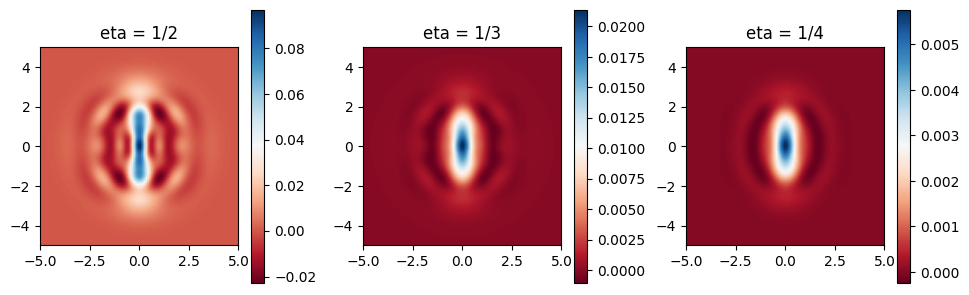

In [13]:
plt.figure(figsize=(16, 12))
for i in range(len(eta_list)):
    plt.subplot(4, 5, i + 1)
    plt.title(f"eta = 1/{eta_list[i]}")
    plt.imshow(wigner_cat[i], extent=[-5, 5, -5, 5], cmap='RdBu')
    plt.colorbar()
plt.tight_layout()
plt.show()


In [14]:
def cat_breeding(eta_list, N, r_vac):
    # vacuum projector on mode 2
    vac = basis(N, 0)
    vac_squeezed = squeeze(N, z=r_vac) * vac

    vac_DM = vac_squeezed * vac_squeezed.dag()

    vac_DM_full = tensor(qeye(N), vac_DM)

    # initial cat state
    cat_state = (coherent(N, alpha=1) - coherent(N, alpha=-1)).unit()
    #mu = np.sqrt(3/2 * np.pi)
    sq = squeeze(N, z=0.5)
    cat_state_squeezed = (sq * cat_state).unit()
    cat_DM = cat_state_squeezed * cat_state_squeezed.dag()

    # lists to save states
    mode_1_list, mode_2_list = [], []
    cat_out_list = []

    current_state = cat_DM  # always density matrix

    for t in eta_list:
        # always tensor density matrices
        two_mode = tensor(current_state, cat_DM)

        # apply BS
        cat_out = BS(t, N, N, two_mode)
        cat_out_list.append(cat_out)

        # project mode 1 onto squeezed vacuum
        projected1 = (vac_DM_full * cat_out * vac_DM_full.dag()).ptrace(0)
        projected2 = (vac_DM_full * cat_out * vac_DM_full.dag()).ptrace(1)

        # normalize
        projected1 = projected1 / projected1.tr()
        projected2 = projected2 / projected2.tr()

        # update for next step
        current_state = projected1
        mode_1_list.append(projected1)
        mode_2_list.append(projected2)

    return mode_1_list, mode_2_list


In [42]:
eta_list = np.arange(2,19)
cat_1mode, cat_2mode = cat_breeding(eta_list, N=30, r_vac=4)

wigner_cat1 = []
wigner_cat2 = []

x = np.linspace(-5, 5, 100)
p = np.linspace(-5, 5, 100)

for i in tqdm(range(len(eta_list)), desc="Computing Wigner functions", unit="iterations"):

        wigner_cat1.append(wigner(cat_1mode[i], x, p))
        #wigner_cat2.append(wigner(cat_2mode[i], x, p))  



Computing Wigner functions:   0%|          | 0/17 [00:00<?, ?iterations/s]

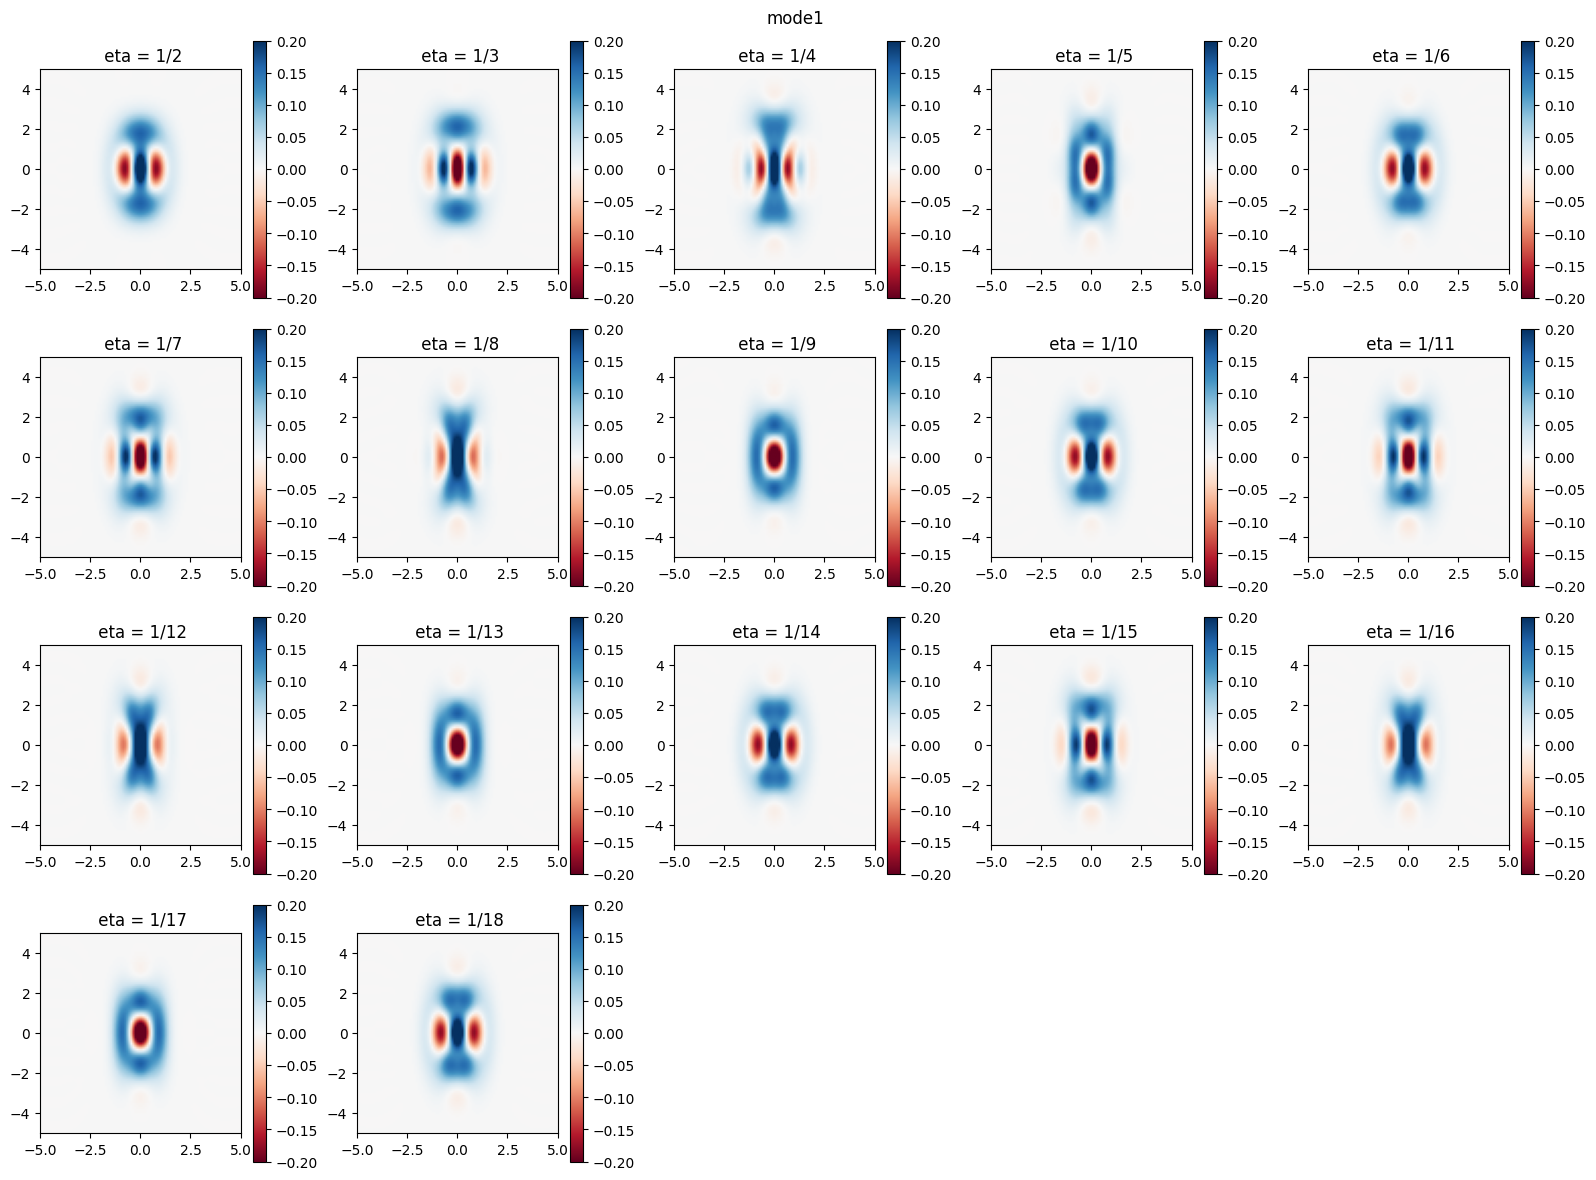

'\nplt.figure(figsize=(16, 12))\nplt.suptitle(\'mode2\')\nfor i in range(len(eta_list)):\n    plt.subplot(4, 5, i + 1)\n    plt.title(f" eta = 1/{eta_list[i]}")\n    plt.imshow(wigner_cat2[i], extent=[-5, 5, -5, 5], vmin = -0.2, vmax = 0.2, cmap=\'RdBu\')\n    plt.colorbar()\nplt.tight_layout()\nplt.show()'

In [43]:
plt.figure(figsize=(16, 12))
plt.suptitle('mode1')

for i in range(len(eta_list)):
    plt.subplot(4, 5, i + 1)
    plt.title(f" eta = 1/{eta_list[i]}")
    plt.imshow(wigner_cat1[i], extent=[-5, 5, -5, 5], vmin = -0.2, vmax = 0.2, cmap='RdBu')
    plt.colorbar()
plt.tight_layout()
plt.show()

"""
plt.figure(figsize=(16, 12))
plt.suptitle('mode2')
for i in range(len(eta_list)):
    plt.subplot(4, 5, i + 1)
    plt.title(f" eta = 1/{eta_list[i]}")
    plt.imshow(wigner_cat2[i], extent=[-5, 5, -5, 5], vmin = -0.2, vmax = 0.2, cmap='RdBu')
    plt.colorbar()
plt.tight_layout()
plt.show()"""

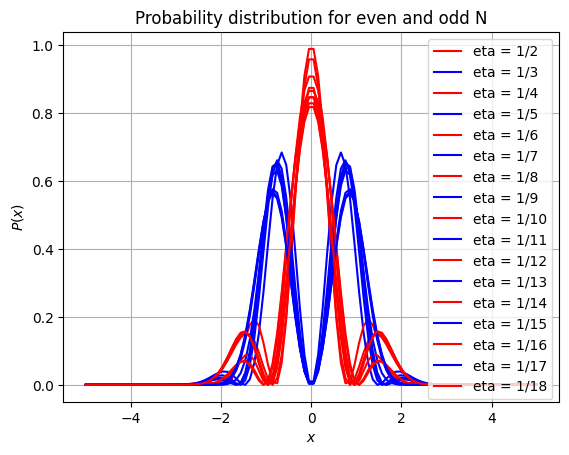

In [44]:
P_x_list = [np.trapezoid(wigner_cat1[i], x, axis=0) for i in range(len(wigner_cat1))]


for i in range(len(wigner_cat1)):
    if i%2 == 0:
        plt.plot(x, P_x_list[i], color ='red',label=f"eta = 1/{eta_list[i]}")
    elif i%2 == 1:
        plt.plot(x, P_x_list[i], color ='blue',label=f"eta = 1/{eta_list[i]}")
plt.xlabel('$x$')
plt.ylabel('$P(x)$')
plt.title('Probability distribution for even and odd N')
plt.legend()
plt.grid()
plt.show()

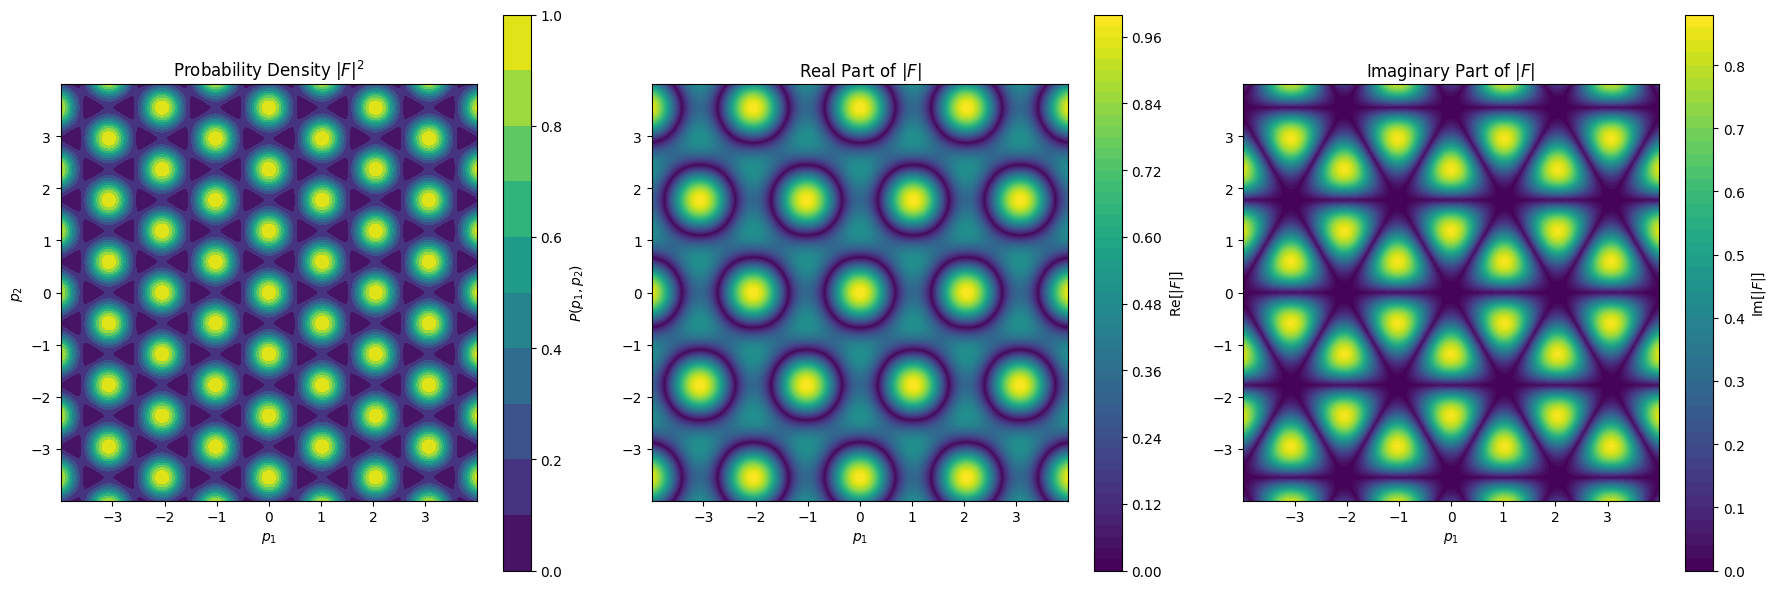

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
hbar = 1
r = 0.2
mu = np.sqrt(3 * np.pi * hbar / 2)  # For qunaught state
#sigma_sq = (hbar / 2) * np.exp(2 * r)  # Variance of p-quadrature

p1_range = np.linspace(-10, 10, 200) * 1/np.sqrt(2*np.pi)
p2_range = np.linspace(-10, 10, 200)  * 1/np.sqrt(2*np.pi)
P1, P2 = np.meshgrid(p1_range, p2_range)

def f1(p1, p2):
    term1 = 2 * np.exp(1j * mu * np.sqrt(2/3) * p2 / hbar) * np.cos(mu * np.sqrt(2) * p1 / hbar)
    term2 = np.exp(-1j * mu * 2 * np.sqrt(2/3) * p2 / hbar)
    return (term1 + term2) / 3  # Normalized to max=1 at p1=p2=0

F = f1(P1, P2)

F_im = np.imag(F)
F_real = np.real(F)
P = np.abs(F)**2


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# |F|² (Probability density)
contour1 = axes[0].contourf(P1, P2, P, levels=np.linspace(0, 1, 11), cmap='viridis')
fig.colorbar(contour1, ax=axes[0], label='$P(p_1, p_2)$')
axes[0].set_title('Probability Density $|F|^2$')
axes[0].set_xlabel('$p_1$')
axes[0].set_ylabel('$p_2$')
axes[0].set_aspect('equal')

# Re(F)
contour2 = axes[1].contourf(P1, P2, abs(F_real), levels=50, cmap='viridis')
fig.colorbar(contour2, ax=axes[1], label='Re[$|F|$]')
axes[1].set_title('Real Part of $|F|$')
axes[1].set_xlabel('$p_1$')
axes[1].set_aspect('equal')

# Im(F)
contour3 = axes[2].contourf(P1, P2, abs(F_im), levels=50, cmap='viridis')
fig.colorbar(contour3, ax=axes[2], label='Im[$|F|$]')
axes[2].set_title('Imaginary Part of $|F|$')
axes[2].set_xlabel('$p_1$')
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()

In [69]:
N = 30
r_cat = 0.3# or just pick r_cat = np.log(1.2)

alpha = np.sqrt(3) * np.sqrt(np.pi/2) * np.exp(r_cat)

# Choose parity: "+" for even cat, "-" for odd cat
parity = -1
cat_state = (coherent(N, alpha) + parity * coherent(N, -alpha)).unit()

sq = squeeze(N, r_cat)
cat_state_squeezed = (sq * cat_state).unit()


In [73]:
N = 30  # Fock cutoff
cat = cat_state_squeezed  # Qobj state in dimension N
#cat = get_input_sq_cat(num, r_dB, parity, which, eta)  # Qobj state in dimension N
p1_range = np.linspace(-2, 2, 50)
p2_range = np.linspace(-2, 2, 50)

Delta_p = np.zeros((len(p1_range), len(p2_range)))

for i, p1 in enumerate(p1_range):
    for j, p2 in enumerate(p2_range):
        alpha = (p1 + 1j*p2).T
        D = displace(N, alpha)
        val = expect(D, cat)
        Delta_p[i, j] = -2 * (abs(alpha)**2) * np.log(abs(val))


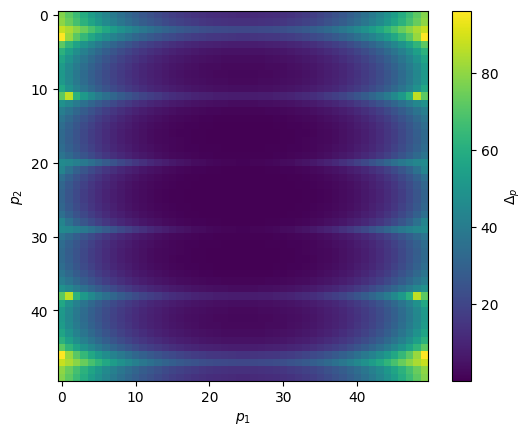

In [74]:
plt.imshow(Delta_p.T,cmap="viridis")
plt.colorbar(label=r"$\Delta_p$")
plt.xlabel(r"$p_1$")
plt.ylabel(r"$p_2$")
plt.show()